### <center>机器学习方法示例：鸢尾花数据集分析</center>

<center><img src='../image/ML_category.png' /></center>

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import os
import sklearn
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
%matplotlib inline

<img src='../image/iris_flower.png' />

In [2]:
from sklearn import datasets

# https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html#sklearn.datasets.load_iris

iris_fpath = Path('../data/iris.csv')

if not iris_fpath.exists():
    Path.mkdir(iris_fpath.parent, exist_ok=True)
    ret = datasets.load_iris(as_frame=True)
    ret.frame.to_csv(iris_fpath, index=False)

# 鸢尾花数据集, shape=(150, 5)
# 前4列为特征列，对应: 花萼长度，花萼宽度，花瓣长度，花瓣宽度
# 目标列为花的分类，取值: 0, 1, 2
df = pd.read_csv(iris_fpath)

df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


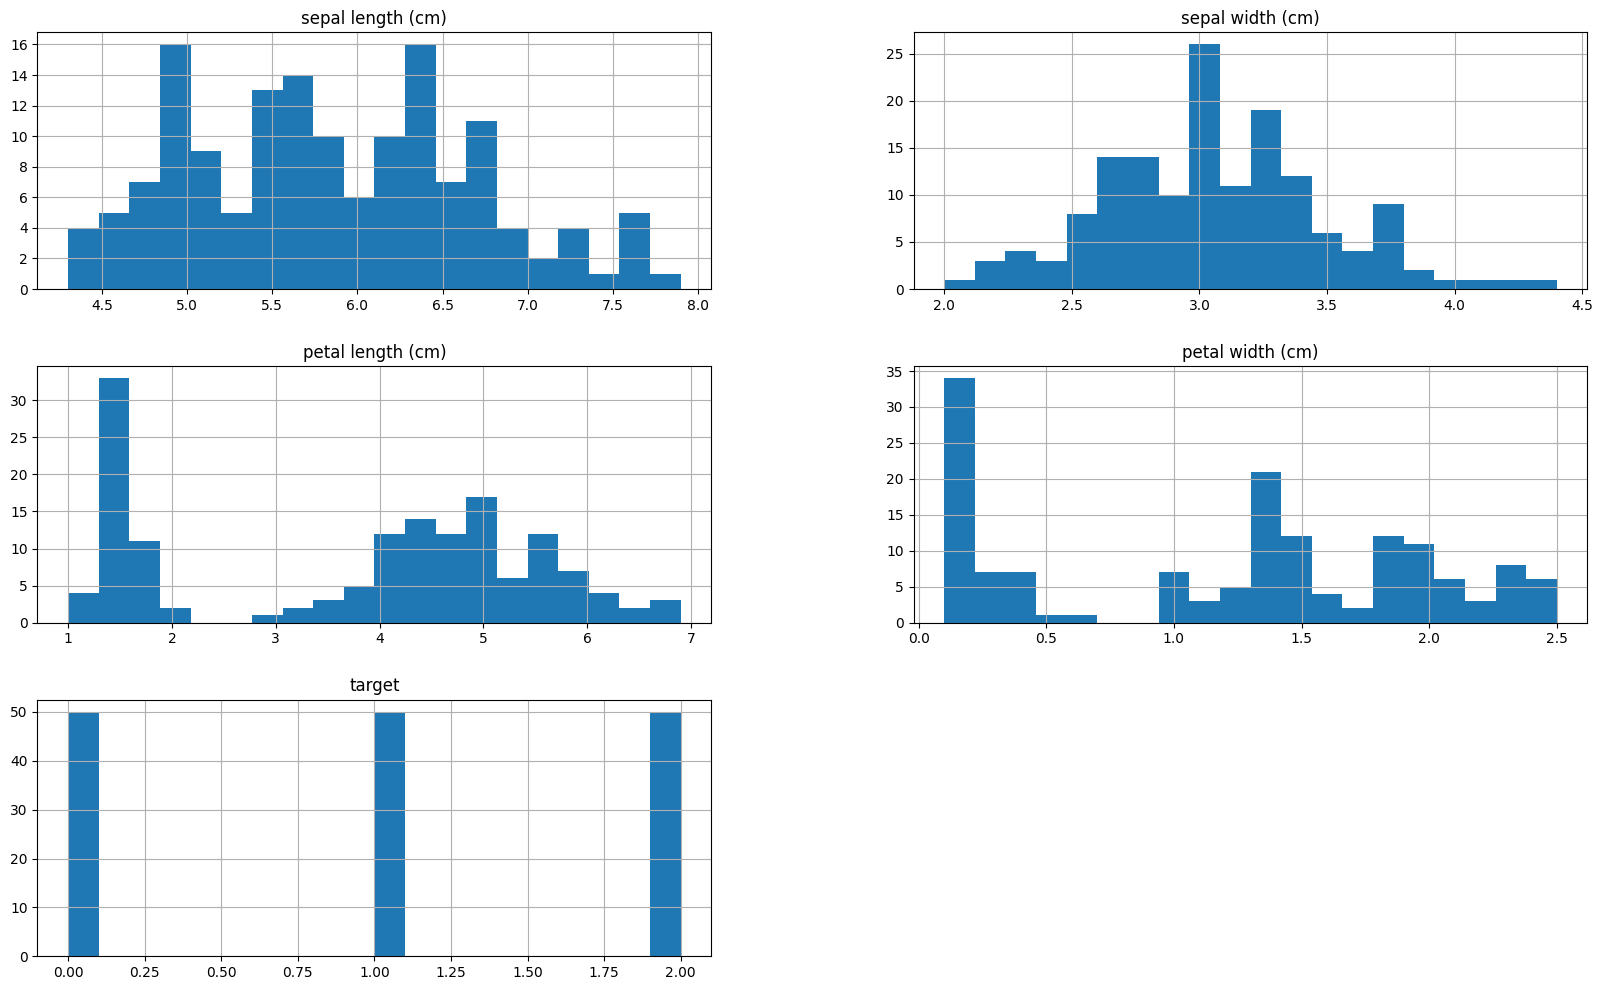

In [14]:
# 查看所有列的数据分布
df.hist(bins=20, figsize=(20, 12))
plt.show()

In [15]:
# 列名重命名
headers = {
    'sepal length (cm)': 'sl',
    'sepal width (cm)': 'sw',
    'petal length (cm)': 'pl',
    'petal width (cm)': 'pw'
}
df.rename(columns=headers, inplace=True)
df.target = df.target.astype(int)

df_raw = df.copy()

# 查看均值，方差
df.describe()

,sl,sw,pl,pw,target
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333,1.000000
std,0.828066,0.435866,1.765298,0.762238,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


In [16]:
# 三个类别的数量统计
df['target'].value_counts()

0    50
1    50
2    50
Name: target, dtype: int64

In [22]:
# 按类别分组, 统计各特征列的均值

# 观察点: 三个分类的花，其 SL/PL/PW 的均值递增，而 SW 则有所不同
# 初步结论：分类0的极易区分，分类1/2较易区分
df.groupby('target').mean(numeric_only=True)

,sl,sw,pl,pw
target,,,,
0,5.006,3.428,1.462,0.246
1,5.936,2.770,4.260,1.326
2,6.588,2.974,5.552,2.026


In [64]:
# 各组数据的统计信息：均值，方差，最小值，最大值等
stats = df.groupby('target').agg(['mean','std','min', 'max']).reset_index()
stats

target     sl                         sw                         pl  \
           mean       std  min  max   mean       std  min  max   mean   
0      0  5.006  0.352490  4.3  5.8  3.428  0.379064  2.3  4.4  1.462   
1      1  5.936  0.516171  4.9  7.0  2.770  0.313798  2.0  3.4  4.260   
2      2  6.588  0.635880  4.9  7.9  2.974  0.322497  2.2  3.8  5.552   

                          pw                      
        std  min  max   mean       std  min  max  
0  0.173664  1.0  1.9  0.246  0.105386  0.1  0.6  
1  0.469911  3.0  5.1  1.326  0.197753  1.0  1.8  
2  0.551895  4.5  6.9  2.026  0.274650  1.4  2.5

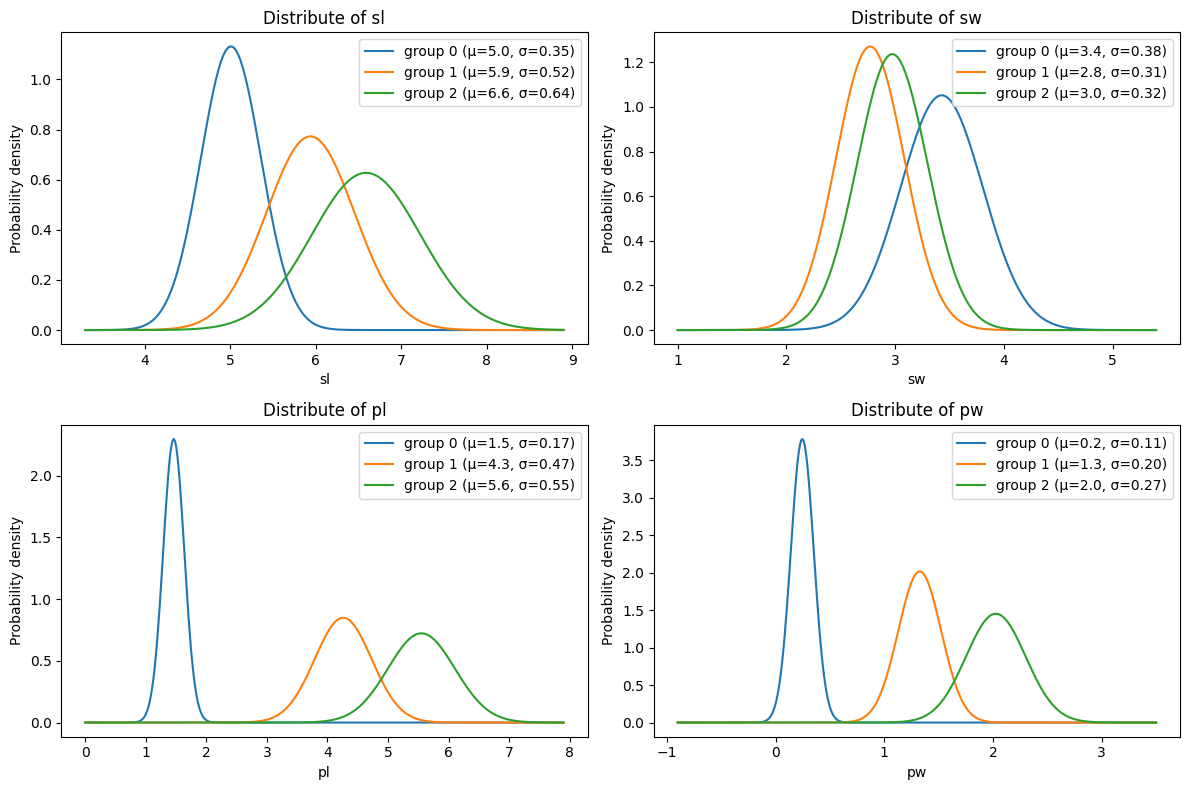

In [ ]:
from scipy.stats import norm

# 将分组后的各特征列的均值和方差，绘制成正态分布曲线
plt.figure(figsize=(12, 8))

for idx, col in enumerate(['sl', 'sw', 'pl', 'pw']):

    plt.subplot(2, 2, idx+1)

    x = np.linspace(df[col].min()-1, df[col].max()+1, 400)  # 横轴范围

    for _, row in stats.iterrows():
        grp, mu, std = row['target'], row[col]['mean'], row[col]['std']
        y = norm.pdf(x, loc=mu, scale=std)
        plt.plot(x, y, label=f'group {int(grp)} (μ={mu:.1f}, σ={std:.2f})')

    plt.title(f'Distribute of {col}')
    plt.xlabel(col)
    plt.ylabel('Probability density')
    plt.legend()
    plt.tight_layout()

    base += 1

plt.show()

In [6]:
# 观察数据列的相关性
# 1. 各特征项与 target 列的相关性
# 2. PL / PW 相关性很高，与 SL 的相关性也较高
df.corr()

,sl,sw,pl,pw,target
sl,1.000000,-0.117570,0.871754,0.817941,0.782561
sw,-0.117570,1.000000,-0.428440,-0.366126,-0.426658
pl,0.871754,-0.428440,1.000000,0.962865,0.949035
pw,0.817941,-0.366126,0.962865,1.000000,0.956547
target,0.782561,-0.426658,0.949035,0.956547,1.000000


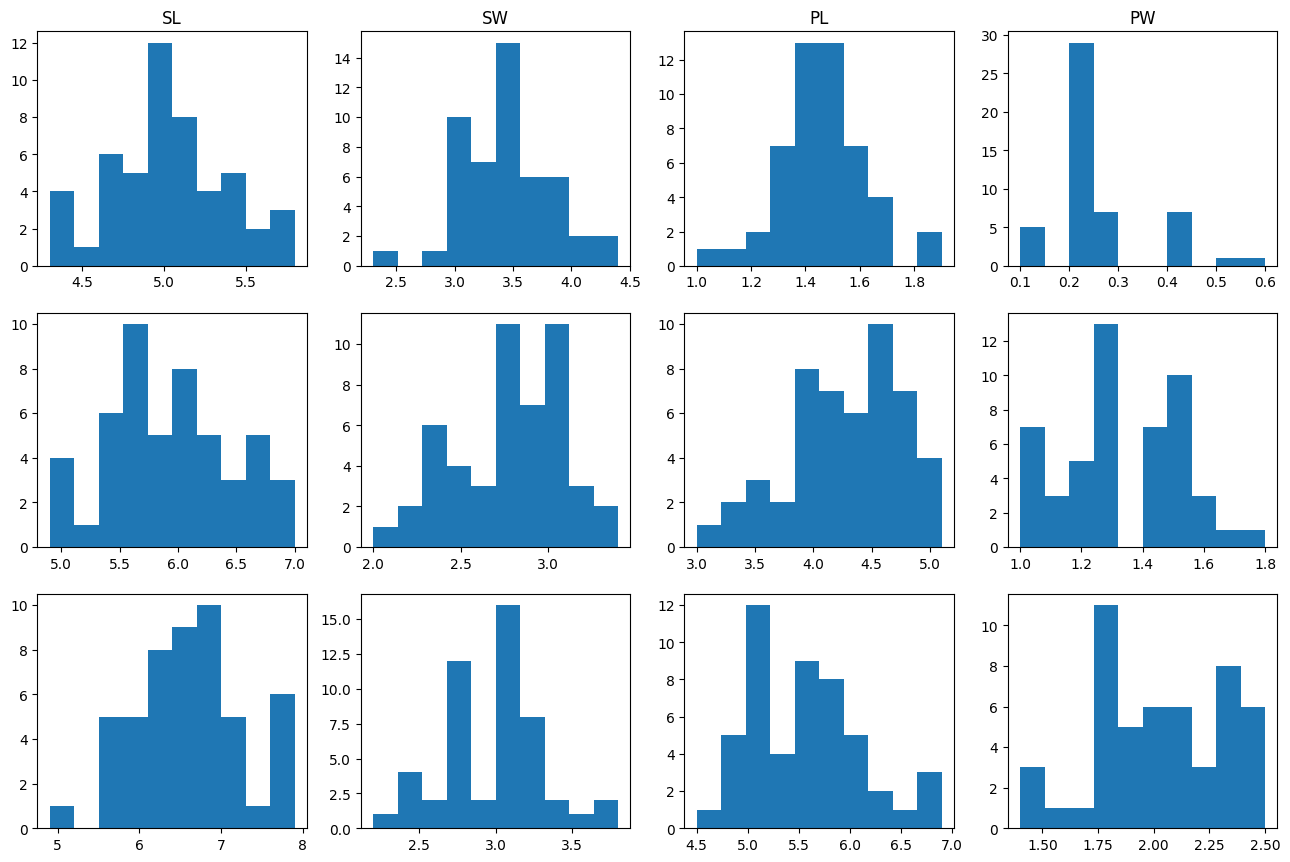

In [62]:
plt.figure(figsize=(16, 14))

# 选择某个类别的花，通过直方图其特征值的分布，这会决定数据预处理和标准化的方式

# 观察1：数值大致符合正态分布
# 观察2：是否有极端的异常值

g0 = df[df.target == 0]
g1 = df[df.target == 1]
g2 = df[df.target == 2]

base = 0

for g in [g0, g1, g2]:

    plt.subplot(4, 4, base+1); plt.hist(g.sl, bins=10)
    if base == 0: plt.title('SL')

    plt.subplot(4, 4, base+2); plt.hist(g.sw, bins=10)
    if base == 0: plt.title('SW')

    plt.subplot(4, 4, base+3); plt.hist(g.pl, bins=10)
    if base == 0: plt.title('PL')

    plt.subplot(4, 4, base+4); plt.hist(g.pw, bins=10)
    if base == 0: plt.title('PW')

    base += 4

plt.show()

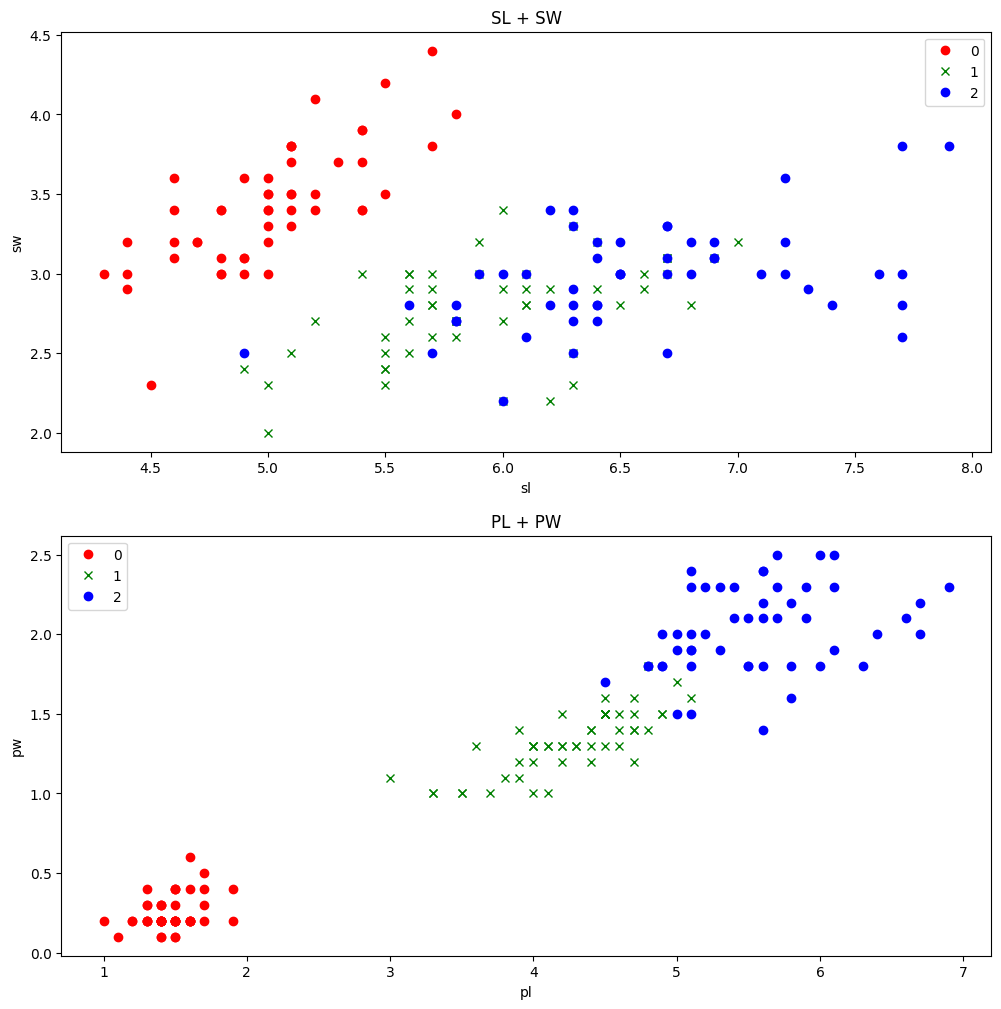

In [65]:
g0 = df[df.target == 0]
g1 = df[df.target == 1]
g2 = df[df.target == 2]

# 绘制散点图
plt.figure(figsize=(12, 12))

# 花萼长度 + 花萼宽度：观察到横轴SL有一定区分度，纵轴SW区分度很低
col_x = 'sl'
col_y = 'sw'
plt.subplot(211)
plt.plot(g0[col_x], g0[col_y], 'ro', label='0')
plt.plot(g1[col_x], g1[col_y], 'gx', label='1')
plt.plot(g2[col_x], g2[col_y], 'bo', label='2')
plt.xlabel(col_x)
plt.ylabel(col_y)
plt.title('SL + SW')
plt.legend()

# 花瓣长度 + 花瓣宽度: 观察到有较好的分类区分度，且PL，PW强相关
col_x = 'pl'
col_y = 'pw'
plt.subplot(212)
plt.plot(g0[col_x], g0[col_y], 'ro', label='0')
plt.plot(g1[col_x], g1[col_y], 'gx', label='1')
plt.plot(g2[col_x], g2[col_y], 'bo', label='2')
plt.xlabel(col_x)
plt.ylabel(col_y)
plt.legend()
plt.title('PL + PW')
plt.show()

### 为什么要对特征列作标准化处理？

不同特征列的物理含义，单位都不一样，计算距离和方差时，容易导致偏差

在模型训练时，如果应用梯度下降法，没有作标准化处理，可能导致收敛速度慢，甚至不收敛

数据标准化，可将各特征列转换为无量纲的数据。当特征列本身符合正态分布时，数据标准化是一种常见的预处理方式。

In [66]:
from sklearn.preprocessing import StandardScaler

# 数据标准化
scaler = StandardScaler()
dfz = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
dfz.target = df.target

dfz.describe()

,sl,sw,pl,pw,target
count,1.500000e+02,1.500000e+02,1.500000e+02,1.500000e+02,150.000000
mean,-4.736952e-16,-7.815970e-16,-4.263256e-16,-4.736952e-16,1.000000
std,1.003350e+00,1.003350e+00,1.003350e+00,1.003350e+00,0.819232
min,-1.870024e+00,-2.433947e+00,-1.567576e+00,-1.447076e+00,0.000000
25%,-9.006812e-01,-5.923730e-01,-1.226552e+00,-1.183812e+00,0.000000
50%,-5.250608e-02,-1.319795e-01,3.364776e-01,1.325097e-01,1.000000
75%,6.745011e-01,5.586108e-01,7.627583e-01,7.906707e-01,2.000000
max,2.492019e+00,3.090775e+00,1.785832e+00,1.712096e+00,2.000000


In [67]:
# 手动计算数据标准化
# z_score = (数据 - 均值) / 标准差
X = df.values[:, :-1]
z = (X - X.mean(axis=0)) / X.std(axis=0)

z[:5], dfz.values[:5]

(array([[-0.90068117,  1.01900435, -1.34022653, -1.3154443 ],
        [-1.14301691, -0.13197948, -1.34022653, -1.3154443 ],
        [-1.38535265,  0.32841405, -1.39706395, -1.3154443 ],
        [-1.50652052,  0.09821729, -1.2833891 , -1.3154443 ],
        [-1.02184904,  1.24920112, -1.34022653, -1.3154443 ]]),
 array([[-0.90068117,  1.01900435, -1.34022653, -1.3154443 ,  0.        ],
        [-1.14301691, -0.13197948, -1.34022653, -1.3154443 ,  0.        ],
        [-1.38535265,  0.32841405, -1.39706395, -1.3154443 ,  0.        ],
        [-1.50652052,  0.09821729, -1.2833891 , -1.3154443 ,  0.        ],
        [-1.02184904,  1.24920112, -1.34022653, -1.3154443 ,  0.        ]]))

In [83]:
# 代码开关：后续的数据分析采用 原始数据 or 标准化数据
do_standardize = True

df = dfz if do_standardize else df_raw

df.head()

,sl,sw,pl,pw,target
0,-0.900681,1.019004,-1.340227,-1.315444,0
1,-1.143017,-0.131979,-1.340227,-1.315444,0
2,-1.385353,0.328414,-1.397064,-1.315444,0
3,-1.506521,0.098217,-1.283389,-1.315444,0
4,-1.021849,1.249201,-1.340227,-1.315444,0


### 数据降维是一种常用的预处理方式

1. 降维到二维或三维，便于可视化，快速建立对数据的直观理解

2. 当原始数据维度较高时，无论是回归、分类、还是聚类任务，通过合适的方式进行降维通常是较好的做法

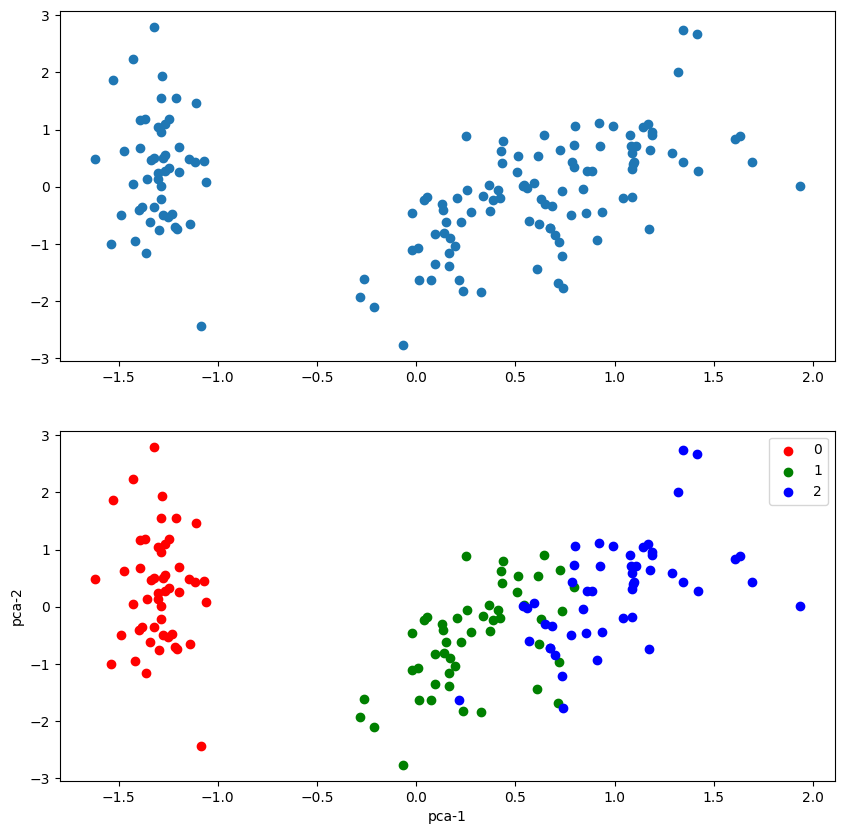

In [104]:
from sklearn.decomposition import PCA

# 参考文章: https://www.cnblogs.com/wj-1314/p/10144700.html
# PCA(主成分分析)，通常用于数据降维
# 在机器学习中，PCA属于特征工程的一种降维算法
# 在本例中，减少到两个特征列，方便可视化
n_components = 2

vals = df.values[:, :-1]
y = df['target'].values

pca = PCA(n_components=n_components, svd_solver="randomized", whiten=True).fit(vals)
pca_vals = pca.transform(vals)

plt.figure(figsize=(10, 10))

# pca后的两个特征列画散点图
plt.subplot(211)
plt.scatter(pca_vals[:, 0], pca_vals[:, 1])

# 按分组标记着色
plt.subplot(212)
for color, i in zip('rgb', [0, 1, 2]):
    plt.scatter(pca_vals[y==i, 0], pca_vals[y==i, 1], c=color, label=i)

plt.xlabel('pca-1')
plt.ylabel('pca-2')
plt.legend()

plt.show()

In [81]:
# 观察PCA降维后，保留了多少方差，即保留了多少信息量
print('保留的总方差', np.sum(np.round(pca.explained_variance_ratio_, 3)))

print('降维后特征列的方差占比：', np.round(pca.explained_variance_ratio_, 3))

保留的总方差 0.959
降维后特征列的方差占比： [0.73  0.229]


### UMAP：非线性降维算法

UMAP = Uniform Manifold Approximation and Projection，统一流形逼近与投影

基于一种称为“流形学习”的技术：假设高维数据存在于一个低维流形上，在低维空间中寻找数据的最佳表示。

其理论基础是黎曼几何和代数拓扑。

umap算法结合了局部邻域结构和全局拓扑信息，能够更好地捕捉数据的非线性结构。

- PCA：线性降维，在数据中保持全局的距离结构
- UMAP：非线性降维，保持局部距离结构

参考文档：https://umap-learn.readthedocs.io/en/latest/index.html

安装：
    pip install umap-learn pandas matplotlib datashader bokeh holoviews scikit-image colorcet

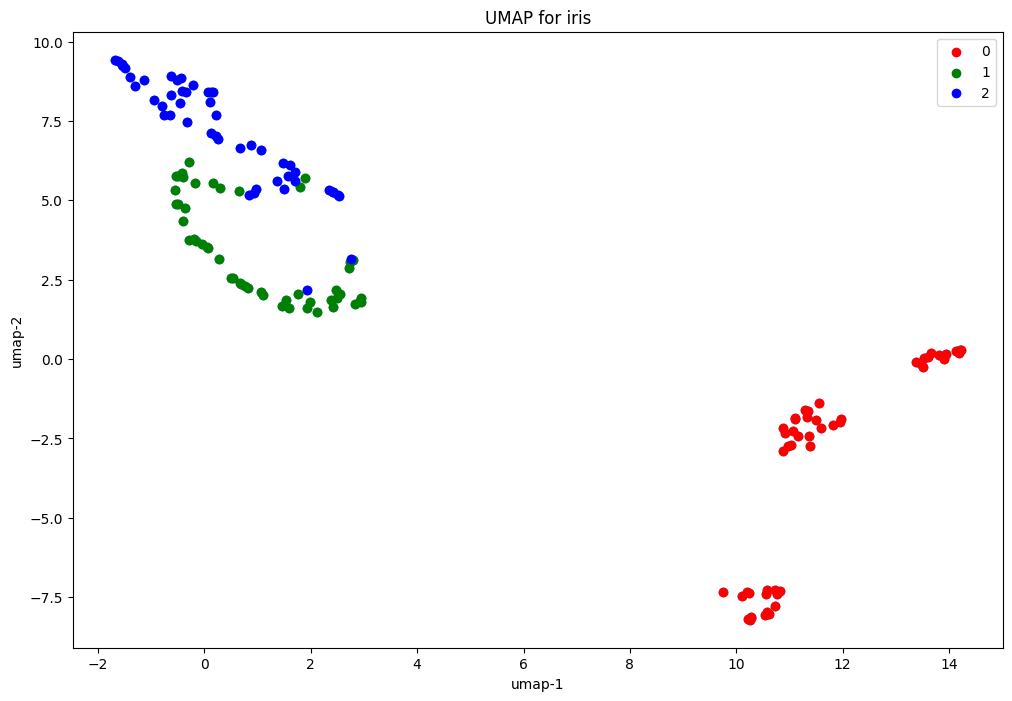

In [85]:
import umap

vals = df.values[:, :-1]
y = df['target'].values

# 几个基本参数：
# n_neighbors: 默认值15，指导算法如何平衡局部和全局的数据距离；
#              较小的取值，会更关注局部；
#              较大的取值，即观察更多邻点，会更关注全局
# min_dist: 默认值 0.1，降维后的点之间的最小距离，
#           较小的min_dist，聚合得更紧密，有利于观察聚类的结构
#           较大的min_dist，避免聚合得过于紧密，有利于观察更宽广的拓扑结构
# n_components: 默认值2，即降维到几列
# metric: 默认值"euclidean", 选择计算距离的方法
umap_vals = umap.UMAP(n_neighbors = 8, n_components=2).fit_transform(vals)

plt.figure(figsize=(12, 8))

# 直接绘制聚类结果
plt.scatter(umap_vals[:, 0], umap_vals[:, 1])

# 按 label 上色的聚类结果
for color, i in zip('rgb', [0, 1, 2]):
    plt.scatter(umap_vals[y==i, 0], umap_vals[y==i, 1], c=color, label=i)

plt.legend()
plt.title('UMAP for iris')
plt.xlabel('umap-1')
plt.ylabel('umap-2')
plt.show()

In [15]:
# 手写数字识别数据集
# 含 70000张 28*28(总共784列) 图片对应的像素值，取值范围 0.0 - 255.0
mnist = sklearn.datasets.fetch_openml("mnist_784", data_home='../data/mnist784', cache=True)
mnist.target.value_counts()

1    7877
7    7293
3    7141
2    6990
9    6958
0    6903
6    6876
8    6825
4    6824
5    6313
Name: class, dtype: int64

In [16]:
# 对 10 个手写数字进行 umap 降维的结果
mapper = umap.UMAP(random_state=42).fit(mnist.data)

### UMAP：手写数字降维

- 降维后能明显观察到10个聚类，对应10个手写数字
- 比较接近的两个聚类，也是容易产生混淆的数字，如3和5，4和9

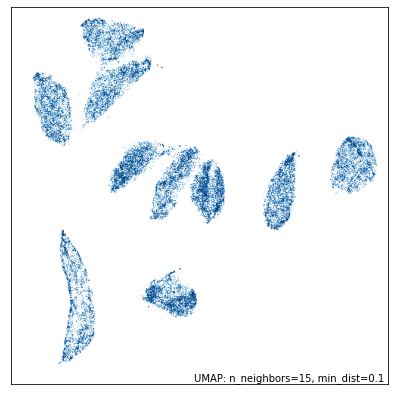

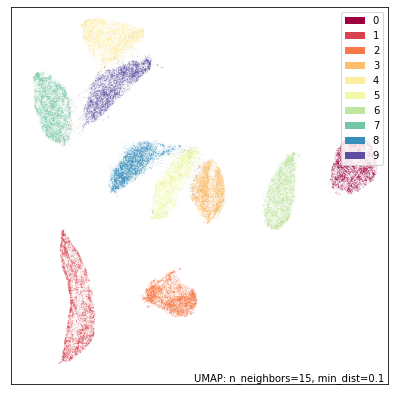

In [17]:
import umap.plot

umap.plot.points(mapper, width=500, height=500)

umap.plot.points(mapper, labels=mnist.target, width=500, height=500)

plt.show()

### 聚类算法：高斯混合模型

高斯混合模型（Gaussian Mixture Model，GMM）是一种聚类方法，它假设数据是由有限个高斯分布混合而成

很多自然现象都符合高斯分布(正态分布)，例如：动植物的高度、体重、寿命...

对鸢尾花数据，根据150条数据的4个特征列，只需知道有3个分类这个信息，使用GMM进行聚类，与标准答案作比较，其分组能达到 96% 的准确率！

<img src='../image/GMM.png' />

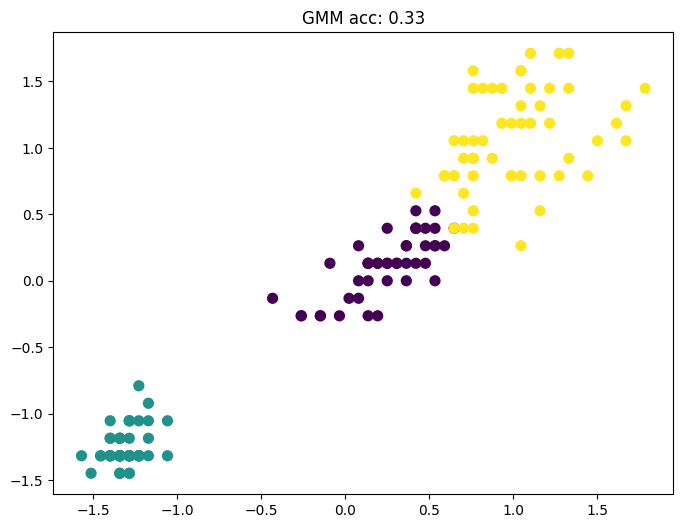

In [106]:
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

def optimal_cluster_gmm(X,n_components_max,random_init=False,n_init=100):
    # n_components_max = 50
    n_neuron = X.shape[0]
    range_n_clusters = list(range(2,n_components_max+1))
    count_n_clusters = len(range_n_clusters)
    # print(random_init)
    if random_init:
        bic = np.ones(count_n_clusters)*np.nan
        aic = np.ones(count_n_clusters)*np.nan
        silhouette_score = np.ones(count_n_clusters)*np.nan
        labels_arr = np.ones((n_neuron,count_n_clusters),dtype=np.dtype('uint8'))      
    else:
        bic = np.ones((count_n_clusters,n_init))*np.nan
        aic = np.ones((count_n_clusters,n_init))*np.nan
        silhouette_score = np.ones((count_n_clusters,n_init))*np.nan
        labels_arr = np.ones((n_neuron,count_n_clusters,n_init),dtype=np.dtype('uint8'))
        
    # print(bic.shape)
    for i,n_cluster in enumerate(range_n_clusters):
        print(n_cluster)
        if random_init:
            gmm = GaussianMixture(n_components=n_cluster,covariance_type='diag', n_init = n_init, max_iter=1000)
            gmm.fit(X)
            labels = gmm.predict(X)
            labels_arr[:,i] = labels
            bic[i] = gmm.bic(X)
            aic[i] = gmm.aic(X)
            silhouette_score[i] = sklearn.metrics.silhouette_score(X,labels) 
        else:
            for j in range(n_init):
                # print(j)
                gmm = GaussianMixture(n_components=n_cluster,covariance_type='diag', random_state = j, max_iter=1000)
                gmm.fit(X)
                labels = gmm.predict(X)
                labels_arr[:,i,j] = labels
                bic[i,j] = gmm.bic(X)
                aic[i,j] = gmm.aic(X)
                silhouette_score[i,j] = sklearn.metrics.silhouette_score(X,labels) 
                
    if random_init:
        bic_plot = bic
        aic_plot = aic
        silhouette_score_plot = silhouette_score
    else:
        bic_plot = np.min(bic,axis=1)
        aic_plot = np.min(aic,axis=1)
        silhouette_score_plot = np.min(silhouette_score,axis=1)
        
    n_cluster = np.argmin(bic_plot)+2
    bic_idx = np.argmin(bic,axis=1)
    labels_arr_optimal = labels_arr[:,n_cluster-2,bic_idx[n_cluster-2]]

    # fig, axs = plt.subplots(3, 1, sharex=True, figsize=(fig_width,fig_height*0.68))
    # axs[0].plot(range_n_clusters,bic_plot,marker='+')
    # axs[0].yaxis.set_major_formatter(FormatStrFormatter('%.2e'))
    # axs[0].legend(['BIC scores'])
    
    
    # axs[1].plot(range_n_clusters,aic_plot,marker='+')
    # axs[1].yaxis.set_major_formatter(FormatStrFormatter('%.2e'))
    # axs[1].legend(['AIC scores'])
    
    # axs[2].plot(range_n_clusters,silhouette_score_plot,marker='+')  
    # axs[2].yaxis.set_major_formatter(FormatStrFormatter('%.2e'))
    # axs[2].legend(['Silhouette scores'])

    # axs[0].title.set_text('The optimal cluster number is '+ str(n_cluster))
    # plt.show() 
      
    print('The optimal cluster number is '+ str(n_cluster))
        
    return n_cluster, aic, bic, silhouette_score, labels_arr, labels_arr_optimal

# 排除 target 列，作无监督的学习
X = df.values[:, :-1]

# sacler = StandardScaler()
# X = sacler.fit_transform(X)

gmm = GaussianMixture(n_components=3).fit(X)
labels = gmm.predict(X)

# GMM无监督学习分类的准确率
acc = np.count_nonzero(labels == df.target) / len(labels)

plt.figure(figsize=(8, 6))
plt.scatter(X[:, 2], X[:, 3], c=labels, s=50, cmap='viridis')
plt.title(f'GMM acc: {acc:.2f}')
plt.show()

In [107]:
# 观察GMM分类的标签，和原始数据的标签
# 把两组数据的标签对齐后，可观察到真实的分类准确率
labels, df.target.values

(array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int64),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 

In [108]:
c1, c3 = np.mean(labels[:3]), np.mean(labels[-3:])
c2 = 3 - c1 - c3

# 重新调整分类标签，使得与原始标签一致
labels_new = np.zeros_like(labels)
for i in range(len(labels)):
    if labels[i] == c1:
        labels_new[i] = 0
    elif labels[i] == c2:
        labels_new[i] = 1
    else:
        labels_new[i] = 2

np.count_nonzero(labels_new == df.target) / len(labels)

0.9666666666666667

### 电生理数据的聚类分析实例

参考论文：[Functional cell types in the mouse superior colliculus](https://elifesciences.org/articles/82367)

记录小鼠上丘的3000多个cell，在不同刺激下的响应数据。通过GMM聚类，选定最优的聚类数量24，即24种功能细胞类型。

最优聚类的判定指标 BIC = Bayesian Information Criterion

数据处理步骤：
- 预处理：所有电生理数据放一起计算均值和方差，执行数据标准化
- 数据降维：6种刺激范式下，电生理时间序列，通过sparse PCA算法进行降维，然后拼接在一起，得到54列特征值。以第4种chirp范式为例，原始序列长度183，降维到20
- GMM聚类：计算不同聚类数量下的BIC指标，选定最佳的聚类数量为24
- 层次聚类：观察功能细胞的层级结构和特点

<img src='../image/BIC_clustering.png' />

基于特征空间中聚类中心的距离，进行层次聚类。树状图的顶层将其划分为两组：
- 第1组：类型 1-10；进一步细分为1a组(类型1–6)和1b组(类型7–10)
- 第2组：类型11-24

<img src='../image/Hierarchical Clustering.png' />

2
3
4
5
6
7
8
9
10
The optimal cluster number is 7


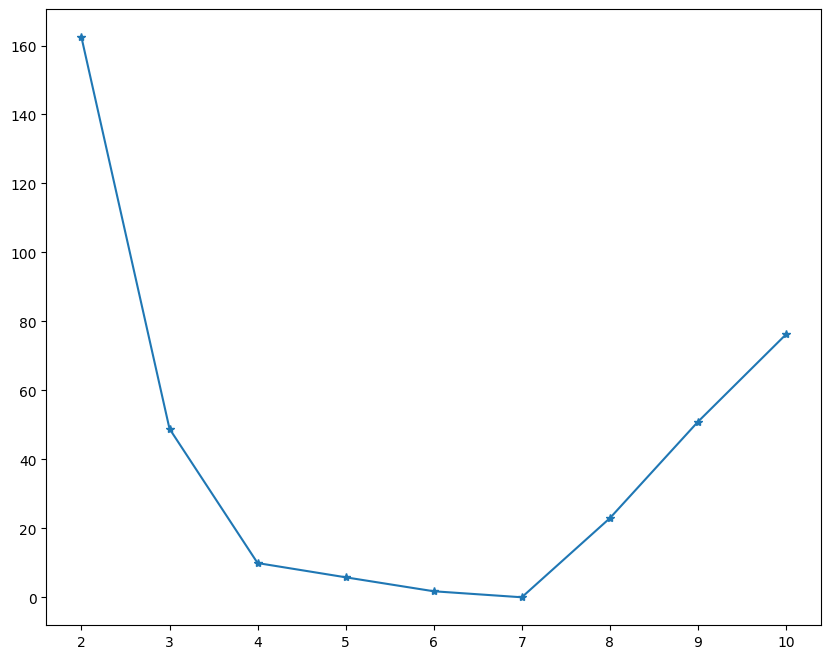

In [ ]:
# 对鸢尾花数据集，尝试聚类数量从 2 到 10，计算 BIC 指标，越小越好
n_components_max = 10

[n_cluster_optimal, _, bic_all, _,labels_arr_all,_] = optimal_cluster_gmm(X, n_components_max, random_init=False, n_init=50)

fig,ax = plt.subplots(1,1,figsize=(10,8))
bic = np.min(bic_all, axis=1)
ax.plot(list(range(2, n_components_max+1)), bic-np.min(bic),'-*')
plt.show()

In [92]:
# 生成训练集，测试集
# 三组花，每组50条，随机选其中40条为训练数据，其余的为测试数据

# 相同的随机seed值，则每次取到同样的抽样结果
def gen_train_test(df, rand = 299):

    n_sample = 40

    g0 = df[df.target == 0]
    g1 = df[df.target == 1]
    g2 = df[df.target == 2]

    df_train = pd.concat([
        g0.sample(n_sample, random_state=rand),
        g1.sample(n_sample, random_state=rand),
        g2.sample(n_sample, random_state=rand)
    ])

    # 求差集，作为测试数据(有两条数据完全一样，所以求差集有时总数会少一条)
    # df_test = df.append(df_train).drop_duplicates(keep=False)

    df_test = pd.concat([df, df_train]).drop_duplicates(keep=False)

    x_train = df_train.values[:, :-1]
    y_train = df_train.target.values

    x_test = df_test.values[:, :-1]
    y_test = df_test.target.values

    return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = gen_train_test(df)

x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_train[0]

((120, 4),
 (120,),
 (29, 4),
 (29,),
 array([-1.38535265,  0.32841405, -1.22655167, -1.3154443 ]))

In [112]:
# 线性回归
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(x_train, y_train)

# 预测结果值(浮点数)四舍五入取整作为分类预测结果
y_pred = np.round(model.predict(x_test))

np.sum(y_pred.astype(int) == y_test.astype(int)) / len(y_pred)
# model.score(x_test, y_test)

0.896551724137931

In [114]:
# 逻辑回归
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=500)
model.fit(x_train, y_train)

model.score(x_train, y_train), model.score(x_test, y_test)

(0.9833333333333333, 0.9310344827586207)

In [95]:
# 作100次随机分组的训练和测试，计算平均准确率
seeds = np.random.randint(low=1, high=10000, size=100)

y_pred = []
y_true = []

for seed in seeds:
    x_train, y_train, x_test, y_test = gen_train_test(df, seed)
    model = LogisticRegression(max_iter=500)
    model.fit(x_train, y_train)
    
    y_pred.append(model.predict(x_test))
    y_true.append(y_test)

y_pred = np.concatenate(y_pred)
y_true = np.concatenate(y_true)

y_pred.shape, y_true.shape

((2968,), (2968,))

In [96]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, roc_auc_score

# 多分类常用的评估指标：准确率，召回率，混淆矩阵
prec, recall, _, _ = precision_recall_fscore_support(y_true, y_pred)

# AUC = roc_auc_score(y_true, y_pred)

total_acc = np.sum(y_pred == y_true) / len(y_pred)

total_acc, prec, recall, confusion_matrix(y_true, y_pred)

(0.956199460916442,
 array([1.        , 0.9298419 , 0.93828452]),
 array([1.        , 0.941     , 0.92665289]),
 array([[1000,    0,    0],
        [   0,  941,   59],
        [   0,   71,  897]], dtype=int64))

### 线性回归效果的评估
- R-squared: 最重要的度量, 变量的变化解释了多少目标量的变化，0.930 表示解释了 93.0% 的变化
- Prob(F-Statistic)： 零假设(线性模型中所有变量的回归系数为0，即所有变量对目标变量无任何关联)的可能性
- coef: 线性回归模型中，各特征变量的系数
- std err: 系数项的标准偏差
- t : 系数项的精度，低标准误差会产生高 t 统计量，意味着系数具有高显著性
- P>|t| : 使用 t 统计量来生成P值，标识零假设(回归系数为0，即该变量与目标变量无任何关联)的可能性

### 线性回归为什么要选择MSE作为损失函数

假设噪声符合高斯分布，选择MSE作为损失函数就是合理的，否则应选其他损失函数

### 统计学上的P值和显著性
P值即概率，反映某一事件发生的可能性大小。

统计学根据显著性检验方法所得到的P值，一般按照：
- P < 0.05  有统计学差异， 
- P < 0.01  有显著统计学差异
- P < 0.001 有极其显著的统计学差异

一个结果是否具有统计意义，取决于在实验开始前设定的显著性水平α, α的选择取决于实际情况和研究领域

0.05 的阈值在文献中造成了太多假阳性。许多研究者在没有理论假设的情况下搜集数据，然后再寻找结果中具有统计显著性的数据模式，这就是 P 值操纵

原子对撞实验中搜集海量数据的粒子物理学家们早就规定，P值的阈值为 3 × 10-7，因为他们担心标准太松的话会出现错误的结论。
遗传学家将全基因组关联研究的阈值定为 5 × 10−8

In [97]:
model = ols('target~sl+sw+pl+pw', data=df).fit()

# R2值，越接近1越好，表示模型拟合的好
# 观察各特征变量的t，P值，对预测效果最有效的变量排序: PW > PL > SL > SW，这与散点图观察到的一致
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                     484.5
Date:                Mon, 22 Sep 2025   Prob (F-statistic):           8.46e-83
Time:                        16:49:22   Log-Likelihood:                 17.437
No. Observations:                 150   AIC:                            -24.87
Df Residuals:                     145   BIC:                            -9.821
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.0000      0.018     55.899      0.0

### <center>线性回归</center>
- 线性模型： $$ y = a_1x_1 + a_2x_2 + ... + k $$
- 预测结果：数值 $$ y \in [-\infty，+\infty] $$
- 计算参数: 线性方程中各项变量对应的系数
- 损失函数：预测值和真实值的平均方差(欧式距离)，优化目标是误差最小
- 优化方法：最小二乘法（Least Square Method），使得损失函数取值最小

### <center>广义线性回归</center>

模型：引入一个新的单调可微函数F，线性模型的结果值再做一次映射，实现输入空间X到输出空间y的非线性映射，例如: 

$$ y = a_1x_1 + a_2x_2 + ... + k $$
$$ z = F(y) = e^y $$

### <center>逻辑回归</center>

- 说明：属于广义线性回归，引入一个函数(如sigmoid)，实现 数值变量 -> [0, 1]的映射，如：
$$ y = sigmoid(a_1x_1 + a_2x_2 + ... + k) $$
- 预测结果：(二分类问题)属于某个分类的概率，取值范围 [0.0, 1.0]
- 损失函数：预测概率与实际分类结果的差异最小，优化目标是联合概率最大
- 优化方法：极大似然法(Maximum Likelihood Method)

[K近邻算法，sklearn官方iris示例](https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_iris.html#sphx-glr-auto-examples-cluster-plot-cluster-iris-py)

In [98]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=5)

model.fit(x_train, y_train)

model.score(x_train, y_train), model.score(x_test, y_test)

# y_pred = model.predict(x_test)

(0.975, 0.8620689655172413)

In [99]:
from sklearn.svm import SVC

model = SVC(probability=True)
model.fit(x_train, y_train)

y_pred = model.predict(x_test)

model.score(x_train, y_train), model.score(x_test, y_test)

(1.0, 0.896551724137931)

In [100]:
# SVM模型还可以输出不同分类评分值和概率值
dec = model.decision_function(x_test)

prob = model.predict_proba(x_test)

# 前5条数据，后5条数据，对三个分类的评分值和概率值
dec[:5], prob[:5], dec[-5:], prob[-5:]

(array([[ 2.22797794,  0.88497734, -0.20692795],
        [ 2.22989958,  0.85846292, -0.19918001],
        [ 2.23062597,  0.85711691, -0.19974502],
        [ 2.22893305,  0.90989844, -0.21523072],
        [ 2.23075381,  0.88721776, -0.21159646]]),
 array([[0.96838101, 0.01874387, 0.01287512],
        [0.96954906, 0.01780359, 0.01264735],
        [0.97114205, 0.01635245, 0.0125055 ],
        [0.97077297, 0.01792436, 0.01130267],
        [0.97349755, 0.01498461, 0.01151784]]),
 array([[-0.22464192,  0.85986569,  2.24543182],
        [-0.2164839 ,  1.10547331,  2.19385092],
        [-0.22904971,  2.19485341,  1.14704318],
        [-0.22938356,  1.12416027,  2.20577093],
        [-0.23107298,  1.17409755,  2.1794627 ]]),
 array([[0.00890741, 0.00325348, 0.9878391 ],
        [0.01948487, 0.21014342, 0.77037172],
        [0.01215422, 0.66076654, 0.32707924],
        [0.01125943, 0.12769684, 0.86104373],
        [0.01206316, 0.36513315, 0.6228037 ]]))

In [101]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()

model.fit(x_train, y_train)

# y_pred = model.predict(x_test)

model.score(x_train, y_train), model.score(x_test, y_test)

# 决策树类型的分类器，还可提供各特征列的重要性作为参考
df.columns, model.feature_importances_

(Index(['sl', 'sw', 'pl', 'pw', 'target'], dtype='object'),
 array([0.08814957, 0.02388716, 0.44350959, 0.44445367]))

1.0 0.9310344827586207


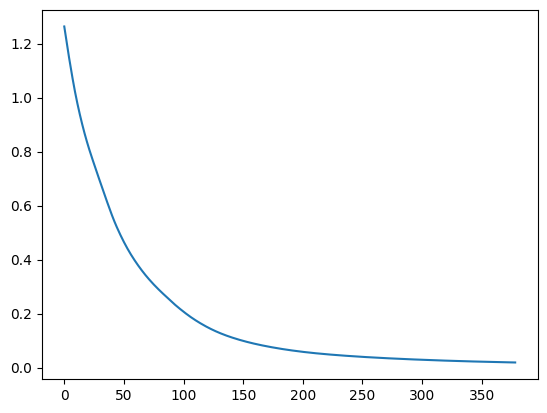

In [102]:
from sklearn.neural_network import MLPClassifier

# 手动指定神经网络的隐藏层
model = MLPClassifier(hidden_layer_sizes=(64, 16), alpha=0.0001, max_iter=3000)

model.fit(x_train, y_train)

# sklearn 的 MLPClassifier 只支持交叉熵损失函数(Cross-Entropy)，它通过运行 predict_proba 方法进行概率估计
# model.predict_proba(x_test)

acc_train = model.score(x_train, y_train)
acc_test = model.score(x_test, y_test)

print(acc_train, acc_test)

plt.plot(model.loss_curve_)
plt.show()

In [103]:
from xgboost import XGBClassifier
model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
model.fit(x_train, y_train)

# y_pred = model.predict(x_test)

model.score(x_train, y_train), model.score(x_test, y_test)

c:\Users\xiewe\miniconda3\envs\torch\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


(1.0, 0.896551724137931)

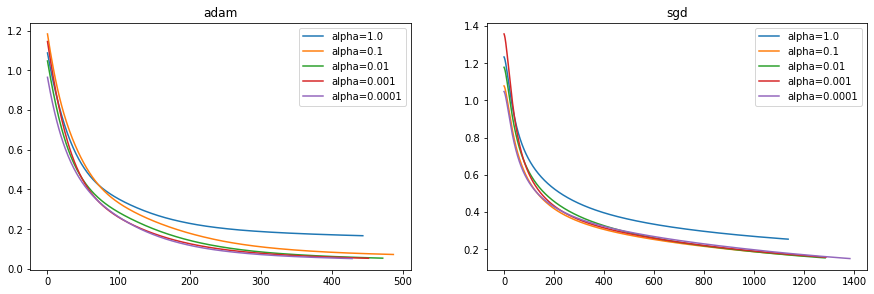

In [35]:
from sklearn.neural_network import MLPClassifier

labels = []

solvers = ['adam', 'sgd']

plt.figure(figsize=(15, 10))

# MLP模型使用不同参数的效果，一般使用默认优化器adam就很好
i = 1
for sol in solvers:
    plt.subplot(2, 2, i)
    for alpha in 10.0 ** -np.arange(0, 5):
        model = MLPClassifier(alpha=alpha, max_iter=3000, solver=sol)
        model.fit(x_train, y_train)
        plt.plot(model.loss_curve_)
        plt.title(sol)

        if i == 1:
            labels.append(f'alpha={alpha}')

    plt.legend(labels, loc='upper right')

    i += 1

plt.show()

In [36]:
# https://scikit-learn.org/stable/modules/preprocessing.html
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

# 如果对数据进行缩放时，训练数据和测试数据，必须使用相同的缩放比例
# 要么切分训练/测试数据前，统一先缩放；要么使用 pipe

# pipe = make_pipeline(StandardScaler(), LinearRegression())
# pipe = make_pipeline(StandardScaler(), LogisticRegression())
pipe = make_pipeline(StandardScaler(), SVC())
# pipe = make_pipeline(StandardScaler(), MLPClassifier(max_iter=3000))
pipe.fit(x_train, y_train)
pipe.score(x_test, y_test)

0.9333333333333333

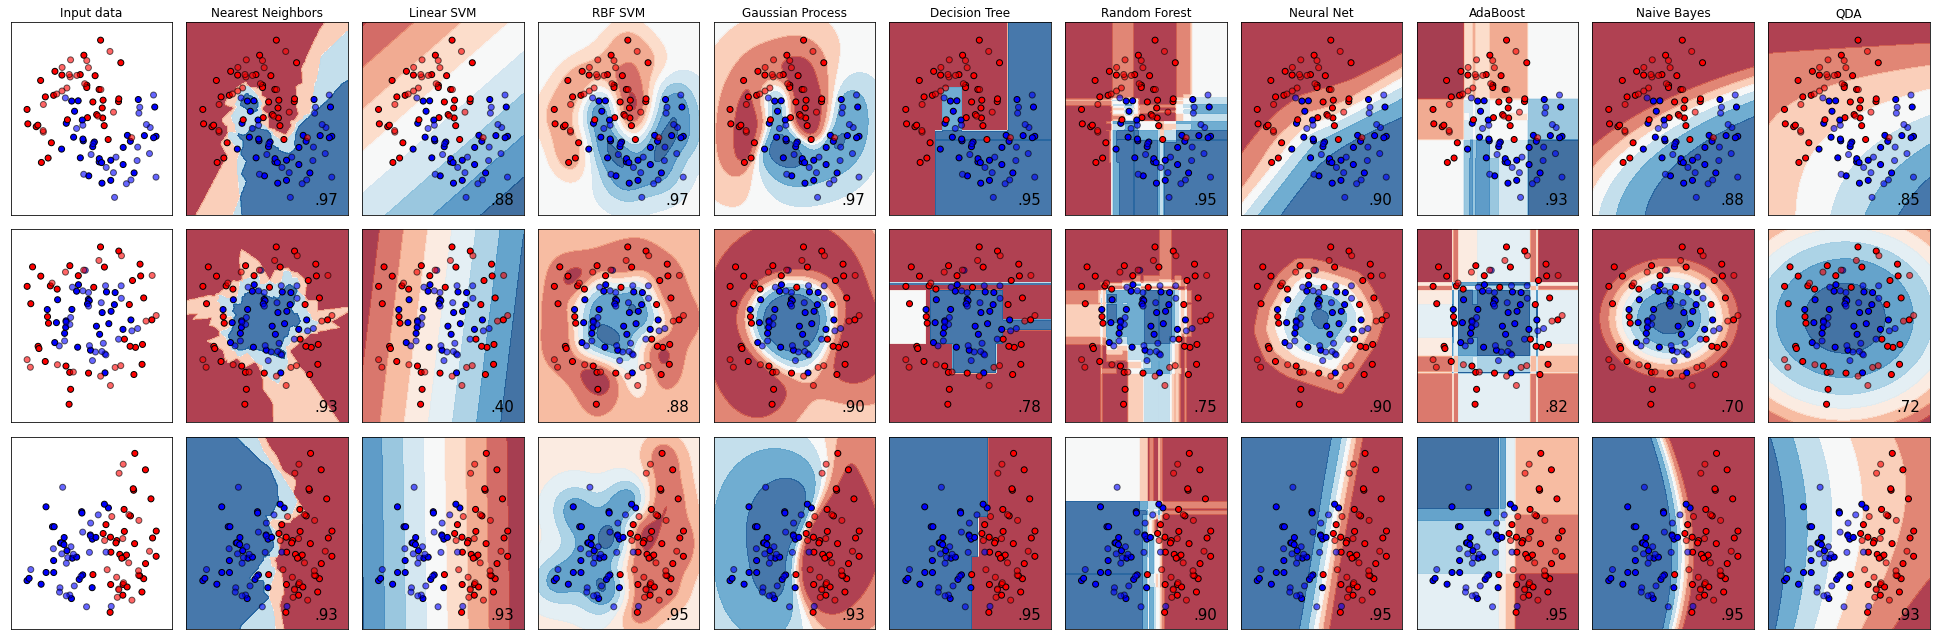

In [37]:
# Code source: Gaël Varoquaux
#              Andreas Müller
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause

# 官方示例：不同分类方法的特点

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

h = .02  # step size in the mesh

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           random_state=1, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [make_moons(noise=0.3, random_state=0),
            make_circles(noise=0.2, factor=0.5, random_state=1),
            linearly_separable
            ]

figure = plt.figure(figsize=(27, 9))
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, Y_train, Y_test = \
        train_test_split(X, y, test_size=.4, random_state=42)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=Y_train, cmap=cm_bright,
               edgecolors='k')
    # Plot the testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=Y_test, cmap=cm_bright, alpha=0.6,
               edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(X_train, Y_train)
        score = clf.score(X_test, Y_test)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # Plot the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=Y_train, cmap=cm_bright,
                   edgecolors='k')
                           # Plot the testing points
        ax.scatter(X_test[:, 0], X_test[:, 1], c=Y_test, cmap=cm_bright,
                   edgecolors='k', alpha=0.6)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=15, horizontalalignment='right')
        i += 1

plt.tight_layout()
plt.show()